# Titanic Project

In this notebook I am working on Kaggle's Titanic dataset. Here I train models to make predictions on the survival of Titanic passengers based upon features such as sex, age and ticket prices. First, I complete some initial data exploration, using some typical Pandas tools, to get a feel and basic understanding of the data. I later do more detailed feature engineering such as null value evaluation, one-hot encoding, and feature scaling. Once the data is processed into X and y training and cross validation data and the models are loaded, predictions are calculated and compared against the true value. The success of these predictions are given by three single valued metrics: accuracy, F1 score and ROC AUC score. These metrics are displayed visually at the bottom of this notebook to display which predictive models worked most successfully. 

This notebook is inspired by work done by others including other Kaggle users, YouTuber Ken Jee, and help from data scientist friends of mine; a particularly special thanks to my close friend Scott Vinay. I understand all code executed below and feel comfortable replicating similar work in future.

### Importing Modules

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import re
from collections import defaultdict
from scipy.spatial.distance import cdist

# Sklearn predictive model modules
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Useful finder function
def find(s, ch):
    return np.array([i for i, ltr in enumerate(s) if ltr == ch]).astype(int)

# Initial Data Exploration and Visualisation

### Basic Dataframe Processing

In the cell below, we do some initial processing of the dataframe. We make all columns lower case and replace any spaces with underscores for easy and consistent referencing. We remove 'passengerid' as it is only another index.

We randomly sample the data to ensure theres no order in the raw data. We also set the random number seed to zero to ensure that when we use the load function we get the same dataframe every time. This is particularly important for when we begin our fold rotations later in the notebook, as it ensures that our training and cross validation data have no overlaps for each distinct fold.

Imagine the dataframe is separated into 4 quarters: A, B, C, D. The fold rotation allows each quarter to be the cross validation data once, and its works as follows: in the first case the quarters A, B, C would be the training data and D would be the cross validation data. Following a single fold B, C, D is now the training data and A is the cross validation. This is repeated until each A, B, C, D quarter is the cross validation data once.

The modulus operator works well here as it returns the division remainder. When x<y, x%y = x. Once x=y, x%y = 0 and the index list begins growing again from zero. This plays the important role of returning to the A quarter indices once the D quarter indices have been exhausted.

To separate the training and cross validation data, we create a new column, 'train'. If a row has a train entry of 1, this is training data. If the entry is 0, this is cross validation data.

In [2]:
# Loading data
def load(fold=0, mode='train'):   
    """
    Loads dataframe from CSV file and performs initial processing.
    
    Parameters
    ---------
        fold : int
            By default '0'.
            This value determines the number of fold rotations executed on the dataframe.
            The dataframe is separated into four quarters, so four folds returns the dataframe
            back to it's initial configuration.
        mode : str
            By default 'train'. Options:
            'train': Loads training data.
            'test' : Loads testing data.
    Returns
    -------
        df : DataFrame
            Processed dataframe.
    """
    
    # Loads dataframe as either training or test data
    if mode=='train':
        df = pd.read_csv('titanic_data/train.csv')
    elif mode=='test':
        df = pd.read_csv('titanic_data/test.csv')
    else:
        raise NotImplementedError
        
    # Initial dataframe processing
    df      = df.rename(columns = {c:c.lower().replace(' ', '_') for c in df.columns})
    df      = df.drop(columns = ['passengerid'])
    
    # Creating 'train' column to separate training and validation data
    # Determinstic random shuffling of the data
    np.random.seed(0)
    df = df.sample(frac=1).reset_index(drop=True)
    indices = df.index
    
    # Separating dataframe into 75/25 training to cross validation data
    tr_idx  = indices[:int(len(indices)*0.75)]
    cv_idx  = indices[int(len(indices)*0.75):]
    
    # Apply a fold rotation, to train and cross validate over whole dataframe when producing results
    tr_idx = (tr_idx + int(len(indices)*fold/4))%len(indices)
    cv_idx = (cv_idx + int(len(indices)*fold/4))%len(indices)
    
    # Defining 'train' column
    df.loc[tr_idx, 'train']=1
    df.loc[cv_idx, 'train']=0
    
    return df

### First Look at The Dataframe

In [3]:
# Loading dataframe
df = load()
df.head()

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,train
0,0,3,"Yousseff, Mr. Gerious",male,NaN,0,0,2627,14.4583,NaN,C,1.0
1,0,3,"Willey, Mr. Edward",male,NaN,0,0,S.O./P.P. 751,7.5500,NaN,S,1.0
2,0,3,"Rice, Master. Eric",male,7.0,4,1,382652,29.1250,NaN,Q,1.0
3,1,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",female,NaN,1,0,PC 17569,146.5208,B78,C,1.0
4,1,3,"Touma, Mrs. Darwis (Hanne Youssef Razi)",female,29.0,0,2,2650,15.2458,NaN,C,1.0


### Data Types and Null Values

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   survived  891 non-null    int64  
 1   pclass    891 non-null    int64  
 2   name      891 non-null    object 
 3   sex       891 non-null    object 
 4   age       714 non-null    float64
 5   sibsp     891 non-null    int64  
 6   parch     891 non-null    int64  
 7   ticket    891 non-null    object 
 8   fare      891 non-null    float64
 9   cabin     204 non-null    object 
 10  embarked  889 non-null    object 
 11  train     891 non-null    float64
dtypes: float64(3), int64(4), object(5)
memory usage: 83.7+ KB


In [5]:
# Isolating features containing null values
nan_features = []
for c in df.columns:
    if df[c].isnull().values.any(): 
        nan_features.append(c)

# Percentage of NaNs for each column with null values
for nf in nan_features:
    nan_percent = 100*df[nf].isnull().sum() /len(df)
    print('The feature',nf,f'is {nan_percent:.3} percent NaN values')

The feature age is 19.9 percent NaN values
The feature cabin is 77.1 percent NaN values
The feature embarked is 0.224 percent NaN values


### Numerical Columns Statistics

In [6]:
df.describe()

,survived,pclass,age,sibsp,parch,fare,train
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208,0.749719
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429,0.433418
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400,0.500000
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,1.000000
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000,1.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000


### Basic Visualisation of Numerical Columns

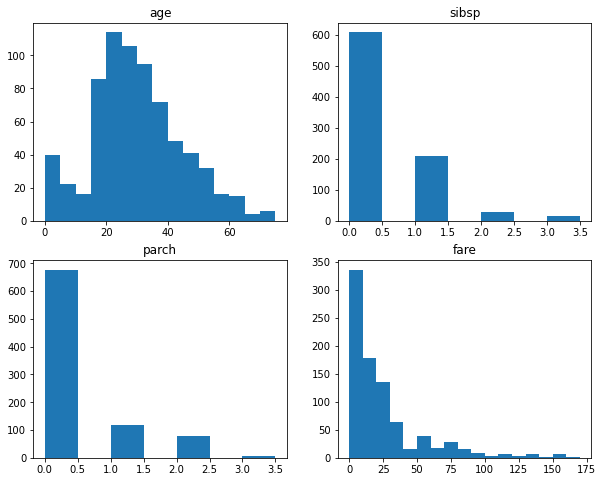

In [7]:
# Separating into numeric and categorical data
num_cols = ['age', 'sibsp', 'parch', 'fare']

# Histogram subplot visualisation of numeric columns
fig, axes = plt.subplots(nrows=2,ncols=2,figsize=[10,8])
axes = axes.flatten()

# Visualisation
count=0
for ax in axes:
    col = num_cols[count]
    bins_=[np.arange(0,80,5), np.arange(0,4,0.5), np.arange(0,4,0.5), np.arange(0,175,10), ]
    ax.hist(df[col],bins=bins_[count])
    ax.set_title(col)
    count+=1

Note: Model might be improved to group sibsp and parch by {0, 1+}

# Processing Dataframe

### Function To Sort Null Values

The code below is used to replace the null values. The null evaluation types we have used below are:

1 - Zero: This method sorts all null values in the dataframe to zero.

2 - Mean: This method calculates the mean of a column using the training data. Then it applies the mean to all null values in the training and cross validation data.

3 - Nearest Neighbour: This method creates a symmetric 2x2 matrix of distances, that is the distance, or similarity, between each of the rows. The value at position (i,j) in our matrix indicates the distance between row i and row j in our dataframe.  As the matrix is symmetric, the value at position (i,j) equals the value at position (j,i). First, we identify which column in our dataframe contains null values, e.g. column x. Next, we create the distance matrix using all columns except for column x. Then, we look through column x to find a row, e.g. row y, that contains a null value. We look along row y in the distance matrix to identify the smallest value, which is given at say position (y,z). Finally, you replace the null value in our dataframe at row y, column x, where there was previously a null value, with the value in row z, column x. This process repeats until all null values are replaced with the value in the row that is most similar to itself. 

There are many different metrics to calculate the distance between rows, here below we have used seuclidean which is the standardised euclidean distance. This differs from the regular euclidean distance by standardising the columns before calculating the distances.

Note: naturally the distance matrix has a trace of zero (zeros along the diagonal) so we have set the diagonal values to purposefully large values to prevent the code from selecting diagonal values as the shortest distance.

In [8]:
# Function to sort the null values 
def fillnull(df, mode = 'zero'):
    """
    Sorts null values of a dataframe.
    
    Parameters
    ---------
        df : DataFrame
            Dataframe that contains null values to be sorted.
            
        mode : By default 'zero'. Options:
            'zero': Sorts null values into zeros.
            'mean': Sorts null values using the mean.
            'near': Sorts null values using the nearest neighbour algorithm
                    on the rows.
    Returns
    -------
        df : DataFrame
            Dataframe with no null values.
    """
    
    if mode=='zero':
        df = df.fillna(0)

    if mode=='mean':
        # Mean of the nf column in training dataframe (don't use cv dataframe as this fits data to cv data)
        mean      = df.loc[df['train']==1, 'age'].mean()
        df['age'] = df['age'].fillna(mean)

    # Using nearest neighbours to sort null values
    if mode=='near':
        df_cols = ['sex', 'sibsp', 'parch', 'fare', 'embarked_C', 'embarked_Q',
                   'embarked_S', 'pclass_1', 'pclass_2', 'pclass_3']

        # Creating distance matrix to find nearest neighbours
        dists   = cdist(df[df_cols].values, df[df_cols].values, 'seuclidean')
        dists   = dists + 1e5*np.identity(dists.shape[0])
        
        # Locates indices of null values
        null_idx     = df.loc[pd.isna(df['age']), :].index
        non_null_idx = df.loc[~pd.isna(df['age']), :].index

        # Loops through rows containing null values
        for i in null_idx:
            # Distances
            distances = list(dists[i, :])
            distance_idx_sorted = sorted(
                                  range(len(distances)), 
                                  key=lambda j: distances[j])
            for k in range(len(distances)):
                if np.isnan(df.loc[k, 'age']) == True:
                    continue
                else:
                    df.loc[i, 'age'] = df.loc[k, 'age']
                    break 

    return df

### Processing Function

The process function below formats our features to allow our machine learning models to make predictions on the data.

We converted the 'sex' column of male,female into 1,0.

To make the fare distribution more uniform we take the logarithm of that feature.

We noticed that the age of people with master as their title was lower than the dataframe mean age. We isolated the ages containing master in the title, calculated their mean and replaced the null values in this subset with this mean.

We one-hot encoded the columns 'embarked' and 'pclass'. This separates these individual columns into n columns, where n is the number of unique values in each column. E.g. the pclass column had entries {1, 2, 3} depending on the ticket class the individual had. After one-hot encoding there are three separate columns: pclass_1, pclass_2 and pclass_3. In a row where pclass is equal to 1, pclass_1 has an entry of 1 and the other columns have an entry of 0 etc. The same thing is done to the embarked column.

Next, we make use of the fillnull function above to take any null values left remaining in the processed dataframe to be replaced. This allows us to use all the rows in the data to make predictions. 

In [9]:
# Processing the dataframe
def process(df, fillnull_mode='zero'):
    """
    This function processes the dataframe into a format required for predictive models.
    It performs feature engineering and separates the dataframe into training and cross validation.
    
    Parameters
    ---------
        df : DataFrame
            Dataframe that requires processing.
            
        fillnull_mode : By default 'zero'. Options:
            'zero': Sorts null values into zeros.
            'mean': Sorts null values using the mean.
            'near': Sorts null values using the nearest neighbour algorithm
                    on the rows.
    Returns
    -------
        dftr : DataFrame
            Training dataframe, used to train the predictive model.
        dfcv : DataFrame
            Cross validation dataframe, used to make and compare predictions
            to test success of predictive models.
        features : list of strings.
    """
    
    # Sorting gender column
    if 'male' in list(df['sex'].values):
        df['sex'] = (df['sex']=='male').astype(int).values
        
    # Taking the logarithm of the fare column to make the distribution more uniform
    df['fare'] = np.log(df.fare+1)
    
    # Sorting age null values using entries in name col containing str 'Master' 
    masterAge_mean = df['age'].loc[df['name'].str.contains('Master')].mean()
    masterAge_mean = round(masterAge_mean, 2)
    df['age'].loc[df['name'].str.contains('Master')] = df['age'].loc[df['name'].str.contains('Master')].fillna(masterAge_mean)
    df.loc[df['name'].str.contains('Master'), 'age'] = df.loc[df['name'].str.contains('Master'), 'age'].fillna(masterAge_mean)
    
    # One-hot encoding 'embarked', 'pclass' columns
    # Embarked column
    df.dropna(subset=['embarked'])
    df_embarked   = pd.get_dummies(df.embarked)
    embarked_cols = list(df_embarked.columns)
    df_embarked = df_embarked.rename(columns = {c: f'embarked_{c}' for c in embarked_cols})
    
    # pclass column
    df_pclass   = pd.get_dummies(df.pclass)
    pclass_cols = list(df_pclass.columns)
    df_pclass   = df_pclass.rename(columns = {c: f'pclass_{c}' for c in pclass_cols})

    # Removing unnecessary columns
    removed_cols = ['name','ticket','embarked','pclass','cabin', 'cabin_number','survived']
    df = pd.concat([df, df_embarked, df_pclass], axis=1)
    df = df[[c for c in df if c not in removed_cols] + ['survived']]
    
    # Sorting null values using fillnull
    df = fillnull(df, fillnull_mode)
    
    # Feature scaling: normalisation
    for nf in num_cols:
        col = df.loc[df['train']==1, nf]
        num_col_mean = col.mean()
        num_col_std  = col.std()
        df[nf] = (df[nf] - num_col_mean)/num_col_std
        
    # Separating into training and cross validation data
    dftr = df[df['train']==1]
    dfcv = df[df['train']==0]
    
    # Removing 'train' column
    df = df.drop(columns = ['train'])
    
    # Finding features
    features = df.columns[:-1]

    return dftr, dfcv, features

# Loading Dataframes and Defining Models

### Loading Data

In [10]:
def get_data_modes(df):
    """
    This function loads data for the different modes.
    It makes use of the process function which processes the data and separates it into
    training and cross validation data. 
    
    Parameters
    ---------
        df : DataFrame
            Dataframe we are loading data from.
    Returns
    -------
        X_modes : dict
            Dictionary containing X data for different modes of null evaluation types.
        ytr : array
            y training data.
        ycv : array
            y cross validation data.
    """
    # Training and cross validation data and features
    dftr_near, dfcv_near, features = process(df, fillnull_mode = 'near')
    dftr_mean, dfcv_mean, features = process(df, fillnull_mode = 'mean')
    dftr_zero, dfcv_zero, features = process(df, fillnull_mode = 'zero')

    # X training data
    Xtr_near = dftr_near[features].values
    Xtr_mean = dftr_mean[features].values
    Xtr_zero = dftr_zero[features].values
    # X cross validation data
    Xcv_near = dfcv_near[features].values
    Xcv_mean = dfcv_mean[features].values
    Xcv_zero = dfcv_zero[features].values

    # X data dictionary
    X_modes = {
        'Near': [Xtr_near, Xcv_near],
        'Mean': [Xtr_mean, Xcv_mean],
        'Zero': [Xtr_zero, Xcv_zero]}

    # y outputs (dftr_mean=dftr_zero and dfcv_mean=dfcv_zero as these values aren't changed by sorting null values)
    ytr = dftr_mean['survived'].values
    ycv = dfcv_mean['survived'].values

    return X_modes, ytr, ycv

In [11]:
# Getting data ready to use below
X_modes, ytr, ycv = get_data_modes(df)

C:\Users\micha\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\micha\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\micha\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 

### Defining the Predictive Models

In [12]:
# Creating models
model_rf = RandomForestClassifier()
model_gb = GradientBoostingClassifier()
model_lr = LogisticRegression(max_iter=1e5)

# Models dictionary
models = {
    'Random Forest': model_rf,
    'Gradient Boosting': model_gb,
    'Logistic Regression': model_lr}

# Results

### Get Result Function

The get_results function produces the metric results using the various different models, which indicates how well the models do when predicting the outcome on the cross validation set. The models are first created using the training data, (Xtr, ytr), and then use the cross validation input data, Xcv, to determine the probabilities of the outcomes, y_prob. These probabilities are used to calculate the outcome predictions, y_pred, which here is determining whether a passenger survived. These probabilities, y_prob, and predictions, y_pred, are then compared directly to the true cross validation output data, ycv, and return a single value metric that allows easy comparison between the different models and null evaluation modes. The there metrics we have used below are the accuracy, F1 score and ROC AUC score.

In [13]:
def get_results(models, X_modes, ytr, ycv):
    """
    Produces the metric results that allow for comparison of models and modes.
    
    Parameters
    ---------
        models : dict
            Dictionary containing predictive models.
        X_modes : dict
            Dictionary containing input training and cross validation
            data for different null evaluation types.
        ytr : numpy.ndarray
            Array containing output training data.
        ycv : numpy.ndarray
            Array containing output cross validation data.
    Returns
    -------
        df_results : DataFrame
            Dataframe containing the results for the models
            and data inputted.
    """
    
    # Creating empty dictionary
    data = defaultdict(list)
    
    # Looping through each model
    for m in models.keys():
        model      = models[m]
        # Looping through each set of X data
        for x in X_modes.keys():
            # Fitting model to X,y training data
            X = X_modes[x][0]
            y = ytr
            model.fit(X,y)
            
            # y prediction using cross validation data
            y_pred = model.predict(X_modes[x][1])
            y_prob = model.predict_proba(X_modes[x][1])
            
            # Evaluation metrics
            acc = accuracy_score(y_pred,ycv)
            f1  = f1_score(y_pred,ycv)
            roc = roc_auc_score(y_prob, ycv)
            
            # Appending values to dataframe
            data['model']   .append(m)
            data['mode']    .append(x)
            data['accuracy'].append(acc)
            data['f1']      .append(f1)
            data['roc_auc'] .append(roc)
            
            # Creating dataframe of results
            df_results = pd.DataFrame(data)
            
    return df_results

In [14]:
pd.options.mode.chained_assignment = None

### Results Dataframe

In [15]:
# Dataframe of models, null evaluation types and metric scores
df_results = get_results(models, X_modes, ytr, ycv)
df_results

ValueError: continuous-multioutput format is not supported

### Best Result Function

This function searches the results dataframe above to extract the best model, null evaluation type and metric score so that it doesn't have to do be done manually. It searches one of the metric columns, finds the maximum value and the index at which the maximum value occurs. It then uses the index to extract the model and mode that correspond to that maximum value.

In [ ]:
def finding_best_results(df_results, metric):
    """
    Finds the best result, along with the model and mode corresponding to it, in the results dataframe. 
    
    Parameters
    ---------
        df_results : DataFrame
            Dataframe of results.
        metric : str
            By default 'f1'. Options:
                'f1': F1 score.
                'accuracy': accuracy score.
    Returns
    -------
        best_model : str
            Model corresponding to metrics highest score.
        best_mode : str
            Mode corresponding to metrics highest score.
        best_score : str
            Best score 
    """
    # Finding the best score in the results table
    best_score = df_results[metric].max()
    idx        = df_results[metric].idxmax()
    best_model = df_results.loc[idx, 'model']
    best_mode  = df_results.loc[idx, 'mode']
    
    return best_model, best_mode, best_score

### Displaying Best Results

In [ ]:
def display_results(df_results):
    """
    Prints the best result, along with the model and mode corresponding to it, in the results dataframe. 
    
    Parameters
    ---------
        df_results : DataFrame
            Dataframe of results.
    Returns
    -------
        best_model : str
            Model corresponding to metrics highest score.
        best_mode : str
            Mode corresponding to metrics highest score.
        best_score : str
            Best score 
    """
    # Finding best results
    best_f1  = finding_best_results(df_results, 'f1')
    best_acc = finding_best_results(df_results, 'accuracy')
    best_roc = finding_best_results(df_results, 'roc_auc')

    # Displaying results
    print(f'Best F1 score: {best_f1[2]:.3f} \nAchieved using {best_f1[0]} and "{best_f1[1]}" null evaluation type.\n')
    print(f'Best accuracy: {best_acc[2]:.3f} \nAchieved using {best_acc[0]} and "{best_acc[1]}" null evaluation type.\n')
    print(f'Best Roc Auc: {best_roc[2]:.3f} \nAchieved using {best_roc[0]} and "{best_roc[1]}" null evaluation type.')

# Printing results
display_results(df_results)

# Visualising Results

The plotter function recieves the results dataframe and plots them in an easily understood bar chat. The models are separated by spaces and the different null value evaluation types are colours.

In [ ]:
def plotter(df, metric='f1'):
    """
    Plots the results of a results dataframe.
    
    Parameters
    ---------
        df : DataFrame
            Dataframe of results.
        metric : str
            By default 'f1'. Options:
                'f1': F1 score.
                'accuracy': accuracy score.
    Returns
    -------
    
    """

    # General figure configuration
    plt.figure(figsize=(10,5))
    sns.set(font_scale=2)
    
    # Creating lists from dataframe
    models         = df['model'].unique()
    nan_eval_types = df['mode'].unique()
    
    # Model separation on graphs
    main_ticks = np.arange(len(models))
    jump = 1/(len(nan_eval_types)+1)
    
    # Looping through each null value evaluation type
    for i, net in enumerate(nan_eval_types):
        # Spacing between models
        xpos = main_ticks + jump*i
        
        # If including error calculation for error bars
        if metric+'_std' in df.columns:
            plot_data = [df.loc[(df['model']==mod) &
                            (df['mode']==net),
                            metric+'_mean'].values[0] for mod in models]
            # Error data
            err_data = [df.loc[(df['model']==mod) &
                            (df['mode']==net),
                            metric+'_std'].values[0] for mod in models]
            plt.bar(
                xpos,
                plot_data,
                yerr = err_data,
                width = jump*0.9,
                label = net.title(),
                capsize=12)

        # If error data not included
        else:
            plot_data = [df.loc[(df['model']==mod) &
                                (df['mode']==net),
                                metric].values[0] for mod in models]

            # Plotting bar charts
            plt.bar(xpos,
                   plot_data,
                   width = jump*0.9,
                   label = net.title())
    
    # Customisation with more specifc customisation depending on metric used
    if metric == 'f1':
        plt.ylabel(r'$F_1$ score')
        plt.title(r'Titanic $F_1$ Scores')
    if metric == 'accuracy':
        plt.ylabel('Accuracy')
        plt.title('Titanic Accuracy Scores')
    if metric == 'roc_auc':
        plt.ylabel('Roc Auc Score')
        plt.title('Titanic Roc Auc Score')
    # Spacing between different models
    plt.gca().set_xticks(main_ticks + jump*(i/2))
    
    # Legend 
    legend = plt.legend(title='Null Value Processing Type', loc=[1.01,0.50])
    plt.setp(legend.get_title(), fontsize=14)
    
    # Limits
    met_min = df_results[metric].min()
    met_max = df_results[metric].max()
    buffer  = (met_max - met_min)*0.75
    plt.ylim([met_min - buffer, met_max + buffer])
    
    # General
    plt.gca().set_xticklabels(models)
    plt.grid(axis='x')
    
    plt.show()

### Visualising Final Results Using Bar Graphs

In [ ]:
plotter(df_results)
plotter(df_results, metric='accuracy')
plotter(df_results, metric='roc_auc')

# Including Error bars

To account for the possibility of getting 'easy' training and cross validation data that could display better results than are true, we have quartered the dataframe and then varied the rotational fold to collect the quarters together with different permutations, as described at the top of this notebook before the load function. An empty list, results_all, is created and recieves an appended dataframe for each of the four rotational folds that the dataframe experiences. Once completed, these dataframes are concatenated together to created one data frame with all the different models, null evaluation types and metric scores.

Next, the dataframe is grouped by model and mode, taking the mean and standard deviation of the accuracy and f1 scores and creating new columns for these values. 

In [ ]:
# Creating a dataframe of results for each different fold rotation
results_all = []
for fold in [0,1,2,3]:
    # Creating new variation of dataframe
    df = load(fold=fold)
    
    # Loading training and cross validation data 
    X_modes, ytr, ycv = get_data_modes(df)
    
    # Calculating results and creating 'fold' column to indicate which rotation the results are associated with
    df_results = get_results(models, X_modes, ytr, ycv)
    df_results['fold'] = fold
    
    # Appending results dataframe
    results_all.append(df_results)
# Combining all data into one dataframe
results_all = pd.concat(results_all)

# Grouping by model and mode, taking the mean and std of the metrics within each group.
results_all = results_all.groupby(['model','mode'])[['accuracy','f1']].agg({'accuracy':['mean','std'], 'f1':['mean','std']}).reset_index(drop=False)
results_all.columns = results_all.columns.map('_'.join)

# Removing underscores from column names that don't require them
results_all = results_all.rename(columns={
    'model_':'model',
    'mode_':'mode'
    })

### Visualising Results With Error Bars

In [ ]:
# Results with error bars
plotter(results_all, metric='f1')
plotter(results_all, metric='accuracy')